In [2]:
%matplotlib inline
import warnings
import inspect
import matplotlib.pyplot as plt
import IPython.display
import numpy as np
from cued_sf2_lab.familiarisation import load_mat_img, plot_image
from cued_sf2_lab.dct import colxfm

# 8 The Lapped Bi-orthogonal Transform (LBT)

<div class="alert alert-warning alert-block">
    
This notebook is incomplete!</div>

<p></p>

<!-- sorry for the nasty HTML, markdown is bad for figures -->

<figure style="text-align: center">
<div class="row">
<figure class="col-md-4 col-md-offset-1">
<img src="figures/lbt.png" style="max-height: 350px" />
<figcaption>(a) Lapped Bi-orthogonal Transform</figcaption>
</figure>

<figure class="col-md-5 col-md-offset-1">
<img src="figures/pot.png" style="max-height: 350px" />
<figcaption>(b) Photo Overlap Transform and a DCT</figcaption>
</figure>
</div>
<div class="row">
<figcaption>
<br />

Figure 4: (a) An LBT transforms overlapping sections of `X` to create `Y`. (b) In some cases
this can be interpreted as pre-filtering with a POT, followed by a DCT.</figcaption></div></figure>

One of the difficulties with the DCT is that it processes each block separately and hence
does not take advantage of any correlation between blocks. A possible solution to this is
to use a _Lapped Bi-orthogonal Transform (LBT)_. These transform overlapping blocks in `X`
to generate smaller non-overlapping blocks in `Y`. In the left-hand figure above, 16 values
in `X` are used to generate each set of 8 values in `Y`.

LBTs are quite complicated to derive and analyse: however one of the most popular forms<sup>3</sup>
can also be represented as a pre-filtering operation before performing the DCT described
in the previous section.
In this case the pre-filtering (or post-filtering for the reverse
operation) is sometimes known as a _Photo Overlap Transform or POT_. A POT followed
by a DCT is then equivalent to a particular type of LBT.

The right-hand figure above demonstrates this. The POT is first performed on a section
of data `X`, shifted by `N/2`, so that it runs across the block boundaries of the subsequent
DCT. Ignoring this block shift for a moment, the forward operation for a 2D image `X` is:


$$Y = C ∗ Pf ∗ X ∗ Pf ′ ∗ C′$$

or in reverse

$$ X = Pr′ ∗ C′ ∗ Y ∗ C ∗ Pr $$

<hr />
<small><sup>3</sup>The type-II fast lapped (bi-)orthogonal transform, or LOT-II</small>

## 8.1 Applying the LBT to images

In [3]:
X, cmaps_dict = load_mat_img(img='lighthouse.mat', img_info='X', cmap_info={'map', 'map2'})
X = X - 128.0

The pre-filtering `Pf ∗ X ∗ Pf′` (with the correct block shift) is straightforward in Python:

```python
t = np.s_[N//2:-N//2]  # N is the DCT size, I is the image size
Xp = X.copy()  # copy the non-transformed edges directly from X
Xp[t,:] = colxfm(Xp[t,:], Pf)
Xp[:,t] = colxfm(Xp[:,t].T, Pf).T
```

This is followed by the DCT `C` as before. In the reverse operation, the inverse DCT `C’` is
performed first, followed by Pr’:
```python
Zp = Z.copy()  #copy the non-transformed edges directly from Z
Zp[:,t] = colxfm(Zp[:,t].T, Pr.T).T
Zp[t,:] = colxfm(Zp[t,:], Pr.T)
```

We have provided a function `pot_ii(N, s)` which will generate a forward (pre-filtering,
`Pf`) and reverse (post-filtering, `Pr`) matrix of size `N` with scaling factor `s`.

In [4]:
from cued_sf2_lab.lbt import pot_ii
from cued_sf2_lab.dct import dct_ii
from cued_sf2_lab.laplacian_pyramid import quantise

# IPython.display.Code(inspect.getsource(pot_ii), language="python")

Edit your code
for performing DCT analysis so that it can pre-filter `X` with `Pf` before the forward DCT,
then post-filter `Z` with `Pr` after the inverse DCT. Confirm that, without quantisation, this
correctly recreates the original image, i.e. `Zp = X`. Use `Pf, Pr = pot_ii(N)` with the
default scaling value `s`.

0.2892780789054325

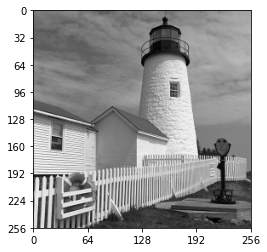

In [5]:
# your code here
def LBT_enc_dec_plot(step,N,s=1,plot = False):
    Pf,Pr = pot_ii(N,s)
    C = dct_ii(N)
    
    t = np.s_[N//2:-N//2]  # N is the DCT size, I is the image size
    Xp = X.copy()  # copy the non-transformed edges directly from X
    Xp[t,:] = colxfm(Xp[t,:], Pf)
    Xp[:,t] = colxfm(Xp[:,t].T, Pf).T
    
    Y = colxfm(colxfm(Xp, C).T, C).T
    
    Yq = quantise(Y,step)

    
    Zq = colxfm(colxfm(Yq.T, C.T).T, C.T)

    Zp = Zq.copy()  #copy the non-transformed edges directly from Z
    Zp[:,t] = colxfm(Zp[:,t].T, Pr.T).T
    Zp[t,:] = colxfm(Zp[t,:], Pr.T)
    
    error = np.std(X-Zp)
    if plot == True:
        fig,ax = plt.subplots()
        plot_image(Zp,ax=ax)
    return(error)
N=8
LBT_enc_dec_plot(1,N,plot=True)

## 8.2 Quantisation and coding efficiency

The scaling factor `s` determines the degree of bi-orthogonality. If `s = 1` then Pf is the same
as Pr, otherwise `1 < s < 2` weights the relative contributions of `Pf` and `Pr` un-equally.

<div class="alert alert-block alert-danger">

For an 8 × 8 DCT, try implementing an LBT with POT scaling factors varying from $1$
to $2$ ($\sqrt{2}$ is often a good choice). In each case find the quantisation step which makes
the rms error match the directly quantised image. Note the compression ratios and find
the scaling factor which maximises these. Also note the visual features in these images.</div>

4.861168497356846


Error with s=1
4.859609080276853


Step size with s=1
23.36000000000223


Compression ratios with s=1
3.0183590086865273


Error with s=1.4142135623730951
4.8608817848093455


Step size with s=1.4142135623730951
25.950000000002635


Compression ratios with s=1.4142135623730951
3.1347093736909115


Error with s=2
4.8601370758555


Step size with s=2
26.440000000002712


Compression ratios with s=2
2.857414142527224


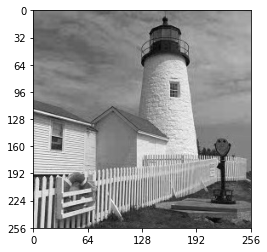

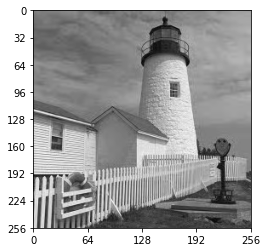

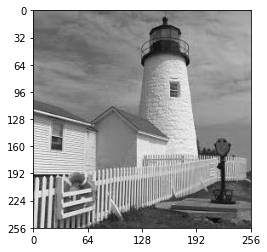

In [6]:
# your code here
from cued_sf2_lab.laplacian_pyramid import bpp  
from cued_sf2_lab.dct import regroup
threshold = np.std(X-quantise(X,17))
print(threshold)
epsilon = 0.01

def gradient_dec_lbt(threshold, epsilon,N,s):
    step = 50
    f_k1 = LBT_enc_dec_plot(step,N,s=s)
    
    while f_k1>threshold:
        # print(f_k1)
        # print("Iterating!")
        backward_step = LBT_enc_dec_plot(step - epsilon,N,s=s)
        forward_step = LBT_enc_dec_plot(step + epsilon,N,s=s)
        if backward_step < forward_step:
            new_step = step - epsilon
            f_k1 = backward_step
        elif backward_step > forward_step:
            new_step = step - epsilon
            f_k1 = forward_step
        

        step = new_step

    return f_k1,new_step

def dctbpp(Yr, N):
    total_bits = 0
    l = int(256/N)
    for i in np.arange(0,256,l):

        
        for j in np.arange(0,256,l):
            subimage = Yr[i:i+l,j:j+l]
            bits_sub = bpp(subimage)*l*l
            total_bits += bits_sub
            
    return total_bits

def c_ratio(X,N,step,s):
    reference_scheme = bpp(quantise(X,17))*256*256
    C = dct_ii(N)

    Pf,Pr = pot_ii(N,s)
    
    t = np.s_[N//2:-N//2]  # N is the DCT size, I is the image size
    Xp = X.copy()  # copy the non-transformed edges directly from X
    Xp[t,:] = colxfm(Xp[t,:], Pf)
    Xp[:,t] = colxfm(Xp[:,t].T, Pf).T
    
    Y = colxfm(colxfm(Xp, C).T, C).T
    
    Yq = quantise(Y,step)
    Yr = regroup(Yq,N)/N
    
    compressed_scheme = dctbpp(Yr,N)
    
    return (reference_scheme/compressed_scheme)


N=8
for s in [1,2**0.5,2]:
    print("\n")
    print("Error with s={}".format(s))
    new_step = gradient_dec_lbt(threshold, epsilon,N,s)[1]
    print(LBT_enc_dec_plot(new_step,8,s,plot = True))
    print("\n")
    print("Step size with s={}".format(s))
    print(new_step)
    print("\n")
    print("Compression ratios with s={}".format(s))
    print(c_ratio(X,N,new_step,s))

The POT can often improve both compression and block smoothing, since the pre-filter
acts to reduce correlations between each DCT sub-block, whilst the inverse post-filter
acts to remove the discontinuities between sub-blocks. This is rather different from the
operation of the DCT. Investigate this by looking at the basis functions, as you did with
the DCT:

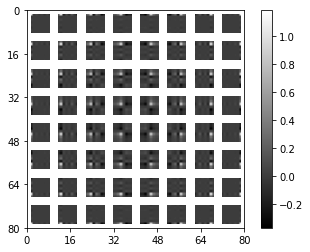

In [7]:
Pf, Pr = pot_ii(8)
bases = np.concatenate([np.full((8,1), np.nan), Pf, np.full((8,1), np.nan)], axis=1)
bases = bases.reshape(-1, 1)
fig, ax = plt.subplots()
im_obj = plot_image(bases @ bases.T, ax=ax)
fig.colorbar(im_obj, ax=ax);

<div class="alert alert-block alert-danger">

Look at both these bases and the pre-filtered image `Xp`, using different scaling factors
`s`, and comment on the visual effect of varying these scaling factors. You may need to
multiply `Xp` by up to 0.5 to display it better.</div>

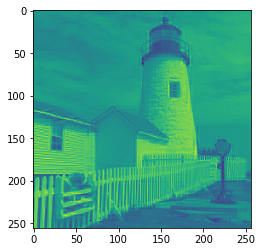

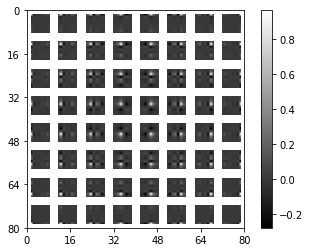

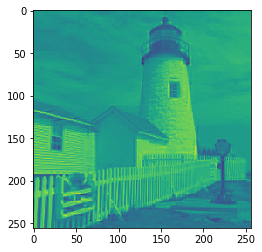

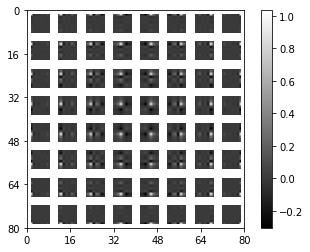

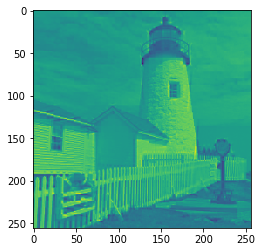

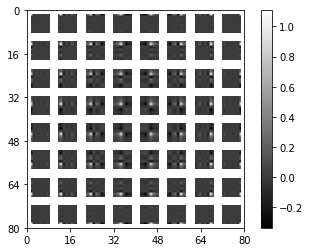

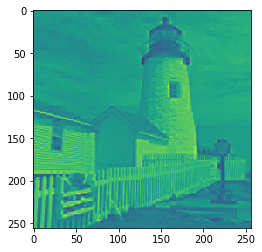

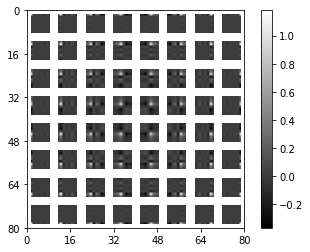

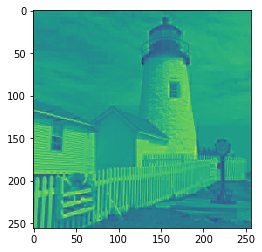

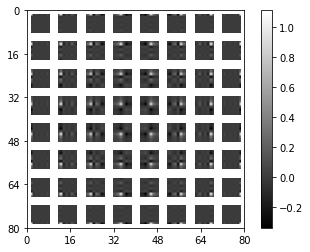

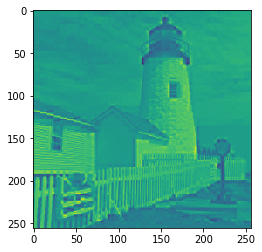

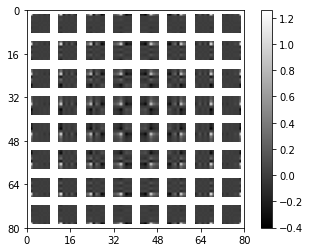

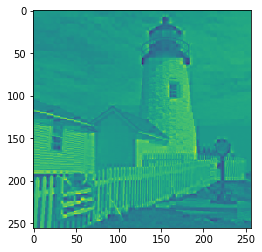

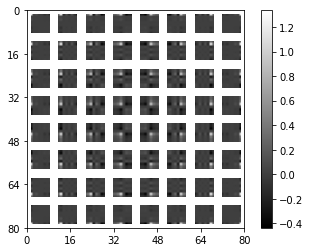

In [8]:
# your code here
for s in [1,1.2,1.4,1.6,2**0.5,1.8,2]:
    Pf,Pr = pot_ii(N,s)
    C = dct_ii(N)
    
    t = np.s_[N//2:-N//2]  # N is the DCT size, I is the image size
    Xp = X.copy()  # copy the non-transformed edges directly from X
    Xp[t,:] = colxfm(Xp[t,:], Pf)
    Xp[:,t] = colxfm(Xp[:,t].T, Pf).T
    plt.imshow(Xp)
    bases = np.concatenate([np.full((8,1), np.nan), Pf, np.full((8,1), np.nan)], axis=1)
    bases = bases.reshape(-1, 1)
    fig, ax = plt.subplots()
    im_obj = plot_image(bases @ bases.T, ax=ax)
    fig.colorbar(im_obj, ax=ax)
    plt.show()
    

With this type of POT / DCT combination it is common to use smaller DCT block sizes
but to code several blocks together. Hence a more accurate estimate of the number of bits
is found by always using 16 × 16 blocks, i.e. regroup `Yq` with the correct size `N` to give
`Yr`, but then always use `dctbpp(Yr, 16)`.

<div class="alert alert-block alert-danger">

Investigate the relative visual and compression performance of LBTs with 4 × 4, 8 × 8
and 16 × 16 blocks, using the scaling factor you have previously selected. As before, be
careful to match the rms error with a directly quantised image.</div>



Error with N=4
4.861158629888068


Step size with N=4
28.86000000000309


Compression ratios with N=4
3.5638331438639743


Error with N=8
4.8608817848093455


Step size with N=8
25.950000000002635


Compression ratios with N=8
3.4231235776921474


Error with N=16
4.8588271450053995


Step size with N=16
22.930000000002163


Compression ratios with N=16
2.9428193561737177


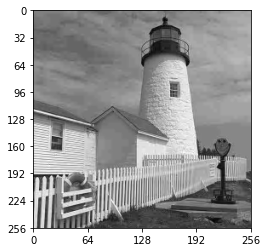

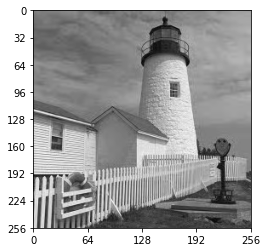

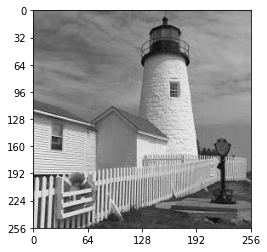

In [11]:
# your code here
s = 2**0.5

def c_ratio_new(X,N,step,s):
    reference_scheme = bpp(quantise(X,17))*256*256
    C = dct_ii(N)

    Pf,Pr = pot_ii(N,s)
    
    t = np.s_[N//2:-N//2]  # N is the DCT size, I is the image size
    Xp = X.copy()  # copy the non-transformed edges directly from X
    Xp[t,:] = colxfm(Xp[t,:], Pf)
    Xp[:,t] = colxfm(Xp[:,t].T, Pf).T
    
    Y = colxfm(colxfm(Xp, C).T, C).T
    
    Yq = quantise(Y,step)
    Yr = regroup(Yq,N)/N
    
    compressed_scheme = dctbpp(Yr,16)
    
    return (reference_scheme/compressed_scheme)

for i in [4,8,16]:
    print("\n")
    print("Error with N={}".format(i))
    new_step = gradient_dec_lbt(threshold, epsilon,i,s)[1]
    print(LBT_enc_dec_plot(new_step,i,s,plot = True))
    print("\n")
    print("Step size with N={}".format(i))
    print(new_step)
    print("\n")
    print("Compression ratios with N={}".format(i))
    print(c_ratio_new(X,i,new_step,s))
    